# Load pipelines
- Ref: https://huggingface.co/docs/diffusers/v0.34.0/en/using-diffusers/loading

In [1]:
#@title
import torch
cpu_use = False
if torch.backends.mps.is_available():
    t_device = torch.device("mps")
    s_device = "mps"
    print(f"Current memory allocated on MPS: {torch.mps.current_allocated_memory()} bytes")
    print(f"Driver memory allocated on MPS: {torch.mps.driver_allocated_memory()} bytes")
elif torch.cuda.is_available():
    t_device = torch.device("cuda")
    s_device = "cuda"
else:
    t_device = torch.device("cpu")
    s_device = "cpu"
    cpu_use = True
print(t_device)

Current memory allocated on MPS: 0 bytes
Driver memory allocated on MPS: 393216 bytes
mps


## 1. Load pipelines


### 1.0.1. Generic pipeline

In [2]:
from diffusers import DiffusionPipeline
from diffusers.utils import load_image
import matplotlib.pyplot as plt

pipeline = DiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", use_safetensors=True).to(t_device)

init_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/img2img-init.png")
prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
image = pipeline("Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", image=init_image).images[0]



/Users/hyunjae.k/anaconda3/envs/2025_drills/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

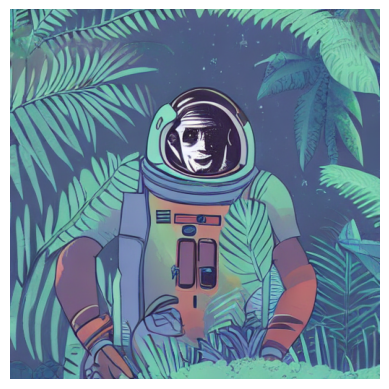

In [3]:
plt.imshow(image)
plt.axis('off')
plt.show()

### 1.0.2. Specific pipeline

In [4]:
from diffusers import StableDiffusionImg2ImgPipeline

pipeline = StableDiffusionImg2ImgPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", use_safetensors=True).to(t_device)

init_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/img2img-init.png")
prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
image = pipeline("Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", image=init_image).images[0]




Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

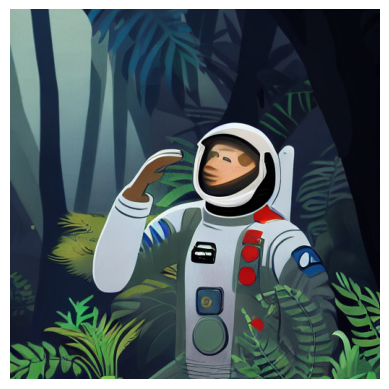

In [5]:
plt.imshow(image)
plt.axis('off')
plt.show()


### 1.1. Specifying Component-Specific Data Types

In [6]:
from diffusers import HunyuanVideoPipeline
import torch

pipe = HunyuanVideoPipeline.from_pretrained(
    "hunyuanvideo-community/HunyuanVideo",
    torch_dtype={"transformer": torch.bfloat16, "default": torch.float16},
).to(t_device)
print(pipe.transformer.dtype, pipe.vae.dtype)  # (torch.bfloat16, torch.float16)



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

torch.bfloat16 torch.float16


### 1.2 Customize a pipeline

In [7]:
from diffusers import StableDiffusionXLPipeline, HeunDiscreteScheduler, AutoencoderKL
import torch
import matplotlib.pyplot as plt

scheduler = HeunDiscreteScheduler.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", subfolder="scheduler")
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16, use_safetensors=True)

# Customize StableDiffusionXLPipeline pipeline with a specific scheduler and vae
pipeline = StableDiffusionXLPipeline.from_pretrained(
  "stabilityai/stable-diffusion-xl-base-1.0",
  scheduler=scheduler,
  vae=vae,
  torch_dtype=torch.float16,
  variant="fp16",
  use_safetensors=True
).to(t_device)

out = pipeline("Astronaut in a jungle, cold color palette, muted colors, detailed, 8k")




Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

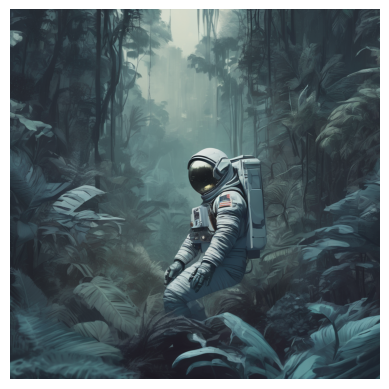

In [8]:
plt.imshow(out.images[0])
plt.axis('off')
plt.show()

### 1.3 Reuse a pipeline

In [9]:
from diffusers import DiffusionPipeline, StableDiffusionSAGPipeline
import torch
import gc
from diffusers.utils import load_image
from accelerate.utils import compute_module_sizes
import matplotlib.pyplot as plt

image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/load_neg_embed.png")

pipe_sd = DiffusionPipeline.from_pretrained("SG161222/Realistic_Vision_V6.0_B1_noVAE", torch_dtype=torch.float16)
pipe_sd.load_ip_adapter("h94/IP-Adapter", subfolder="models", weight_name="ip-adapter_sd15.bin")
pipe_sd.set_ip_adapter_scale(0.6)
pipe_sd.to(t_device)

generator = torch.Generator(device="cpu").manual_seed(33)
out_sd = pipe_sd(
    prompt="bear eats pizza",
    negative_prompt="wrong white balance, dark, sketches,worst quality,low quality",
    ip_adapter_image=image,
    num_inference_steps=50,
    generator=generator,
)



Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /Users/hyunjae.k/.cache/huggingface/hub/models--SG161222--Realistic_Vision_V6.0_B1_noVAE/snapshots/9a857a696b9aabbf509073e0aa55ec8200b6ef7d/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/hyunjae.k/.cache/huggingface/hub/models--SG161222--Realistic_Vision_V6.0_B1_noVAE/snapshots/9a857a696b9aabbf509073e0aa55ec8200b6ef7d/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/Users/hyunjae.k/anaconda3/envs/2025_drills/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:30: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
An error occurred while trying to fetch /Users/hyunjae.k/.cache/huggingface/hub/models--SG161222--Realistic_Vision_V6.0_B1_noVAE/snapshots/9a857a696b9aabbf509073e0aa55ec8200b6ef7d/vae: Error no file named diff

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/xk/hd_6wmxj32ngdnnm2x5h1_7r0000gn/T/ipykernel_21875/3620861688.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


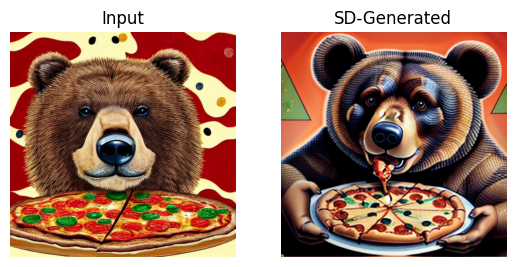

In [10]:
# Display Image
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[0].set_axis_off()
axs[0].set_title("Input")
axs[1].imshow(out_sd.images[0])
axs[1].set_axis_off()
axs[1].set_title("SD-Generated")
fig.show()

In [11]:
pipe_sag = StableDiffusionSAGPipeline.from_pipe(
    pipe_sd
)

generator = torch.Generator(device="cpu").manual_seed(33)
out_sag = pipe_sag(
    prompt="bear eats pizza",
    negative_prompt="wrong white balance, dark, sketches,worst quality,low quality",
    ip_adapter_image=image,
    num_inference_steps=50,
    generator=generator,
    guidance_scale=1.0,
    sag_scale=0.75
)


The StableDiffusionSAGPipeline has been deprecated and will not receive bug fixes or feature updates after Diffusers version 0.33.1. 


  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/xk/hd_6wmxj32ngdnnm2x5h1_7r0000gn/T/ipykernel_21875/2458320653.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


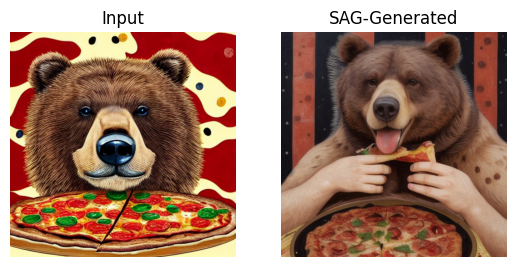

In [12]:
# Display Image
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[0].set_axis_off()
axs[0].set_title("Input")
axs[1].imshow(out_sag.images[0])
axs[1].set_axis_off()
axs[1].set_title("SAG-Generated")
fig.show()

In [13]:

from diffusers import AnimateDiffPipeline, MotionAdapter, DDIMScheduler
from diffusers.utils import export_to_gif
from IPython import display

pipe_sag.unload_ip_adapter()
adapter = MotionAdapter.from_pretrained("guoyww/animatediff-motion-adapter-v1-5-2", torch_dtype=torch.float16)

pipe_animate = AnimateDiffPipeline.from_pipe(pipe_sd, motion_adapter=adapter)
pipe_animate.scheduler = DDIMScheduler.from_config(pipe_animate.scheduler.config, beta_schedule="linear")
# load IP-Adapter and LoRA weights again
pipe_animate.load_ip_adapter("h94/IP-Adapter", subfolder="models", weight_name="ip-adapter_sd15.bin")
pipe_animate.load_lora_weights("guoyww/animatediff-motion-lora-zoom-out", adapter_name="zoom-out")
pipe_animate.to("cpu") # Memoey Issue on MAC and Linux

generator = torch.Generator(device="cpu").manual_seed(33)
pipe_animate.set_adapters("zoom-out", adapter_weights=0.75)
out_ani = pipe_animate(
    prompt="bear eats pizza",
    num_frames=16,
    num_inference_steps=50,
    ip_adapter_image=image,
    generator=generator,
)

The config attributes {'motion_activation_fn': 'geglu', 'motion_attention_bias': False, 'motion_cross_attention_dim': None} were passed to MotionAdapter, but are not expected and will be ignored. Please verify your config.json configuration file.
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/50 [00:00<?, ?it/s]

In [14]:
# export_to_gif(out_ani.frames[0], "temp_out_animate.gif")
display.HTML('<img src="temp_out_animate.gif">')

### 1.4 Safety Checker

In [15]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", safety_checker=None, use_safetensors=True)
"""
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide by the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend keeping the safety filter enabled in all public-facing circumstances, disabling it only for use cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
"""

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


"\nYou have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide by the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend keeping the safety filter enabled in all public-facing circumstances, disabling it only for use cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .\n"